/home/milky/drosophila-SNA/.env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/home/milky/drosophila-SNA/.env/lib/python3.8/site-packages/statsmodels/sandbox/stats/multicomp.py:1300: RuntimeWarning: invalid value encountered in divide
  st_range = np.abs(meandiffs) / std_pairs #studentized range statistic


=============================================Total nodes=============================================
sum_CS_10D mean value: 12.0 SD value: 0.0
sum_CsCh mean value: 12.0 SD value: 0.0
sum_Cs_5DIZ mean value: 12.0 SD value: 0.0
sum_LDA_5DIZ mean value: 12.0 SD value: 0.0
sum_OCT_5DIZ mean value: 12.0 SD value: 0.0
sum_LDA_OCT_5DIZ mean value: 12.0 SD value: 0.0
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
   group1       group2    meandiff p-adj lower upper reject
-----------------------------------------------------------
      CS_10D         CsCh      0.0   nan   0.0   0.0  False
      CS_10D      Cs_5DIZ      0.0   nan   0.0   0.0  False
      CS_10D     LDA_5DIZ      0.0   nan   0.0   0.0  False
      CS_10D LDA_OCT_5DIZ      0.0   nan   0.0   0.0  False
      CS_10D     OCT_5DIZ      0.0   nan   0.0   0.0  False
        CsCh      Cs_5DIZ      0.0   nan   0.0   0.0  False
        CsCh     LDA_5DIZ      0.0   nan   0.0   0.0  False
        CsCh LDA_OCT_5DIZ      0.0   

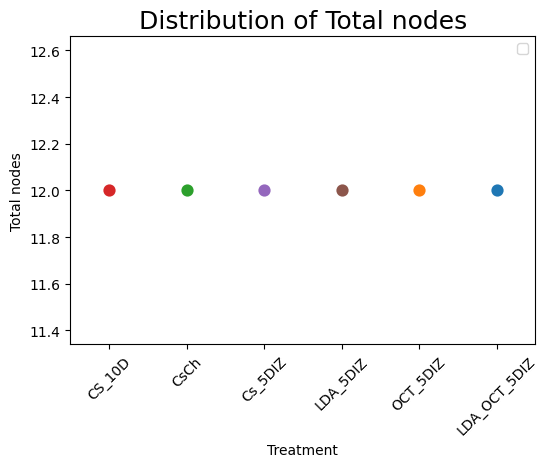

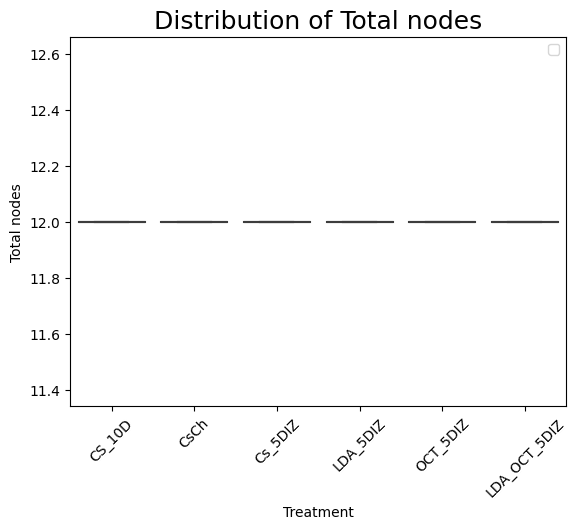

=============================================Total edges=============================================
sum_CS_10D mean value: 132.0 SD value: 0.0
sum_CsCh mean value: 132.0 SD value: 0.0
sum_Cs_5DIZ mean value: 132.0 SD value: 0.0
sum_LDA_5DIZ mean value: 132.0 SD value: 0.0
sum_OCT_5DIZ mean value: 132.0 SD value: 0.0
sum_LDA_OCT_5DIZ mean value: 130.27272727272728 SD value: 3.4136333373670156
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
      CS_10D         CsCh      0.0    1.0 -0.9707  0.9707  False
      CS_10D      Cs_5DIZ      0.0    1.0 -1.0031  1.0031  False
      CS_10D     LDA_5DIZ      0.0    1.0 -0.9615  0.9615  False
      CS_10D LDA_OCT_5DIZ  -1.7273 0.0007 -2.9136  -0.541   True
      CS_10D     OCT_5DIZ      0.0    1.0 -1.0159  1.0159  False
        CsCh      Cs_5DIZ      0.0    1.0 -0.9573  0.9573  False
        CsCh     L

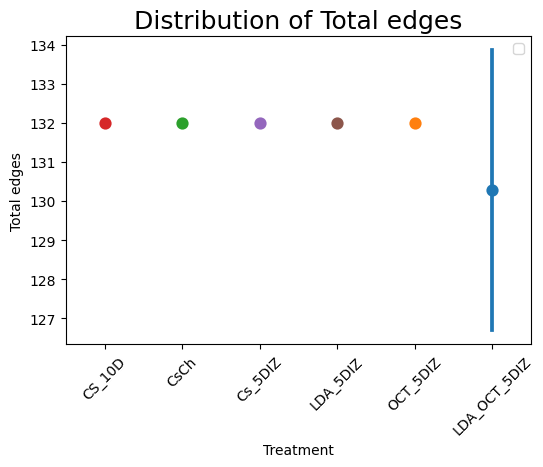

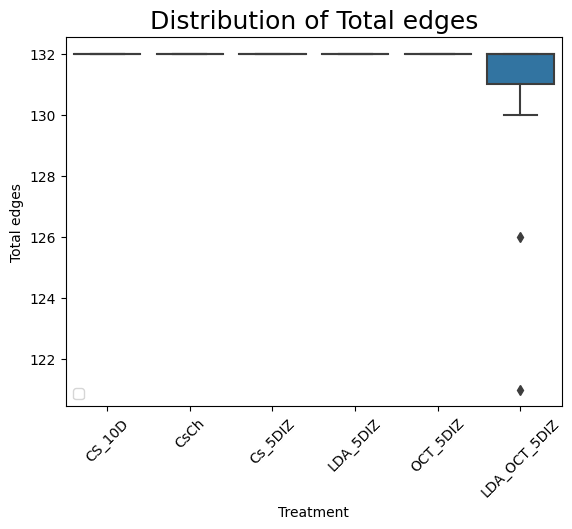

=============================================Average degree weight=count=============================================
sum_CS_10D mean value: 387.2368421052632 SD value: 91.07634988379999
sum_CsCh mean value: 481.6884057971014 SD value: 76.98304764055891
sum_Cs_5DIZ mean value: 424.3833333333333 SD value: 48.53850418882816
sum_LDA_5DIZ mean value: 460.1319444444444 SD value: 83.6878013806244
sum_OCT_5DIZ mean value: 474.3771929824561 SD value: 62.260367325362544
sum_LDA_OCT_5DIZ mean value: 480.75757575757575 SD value: 95.50227041661947
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
   group1       group2    meandiff p-adj    lower    upper   reject
-------------------------------------------------------------------
      CS_10D         CsCh  94.4516 0.0025   23.5896 165.3135   True
      CS_10D      Cs_5DIZ  37.1465 0.6831  -36.0803 110.3732  False
      CS_10D     LDA_5DIZ  72.8951 0.0369    2.7042  143.086   True
      CS_10D LDA_OCT_5DIZ  93.5207 0.0263     6.92

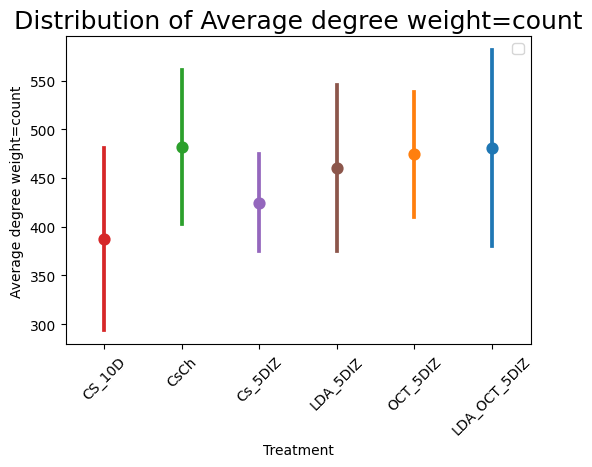

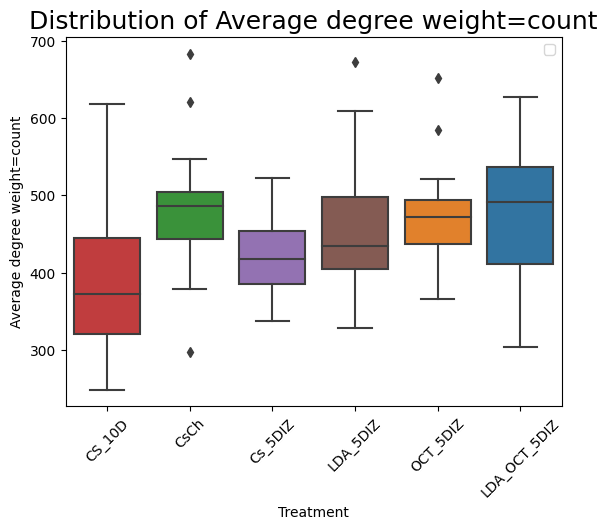

=============================================Average degree weight=duration(seconds)=============================================
sum_CS_10D mean value: 751.9396929824562 SD value: 211.93467434652183
sum_CsCh mean value: 556.8762077294685 SD value: 113.42069244611899
sum_Cs_5DIZ mean value: 569.2222222222222 SD value: 162.88645356332347
sum_LDA_5DIZ mean value: 565.6909722222222 SD value: 135.6416429625788
sum_OCT_5DIZ mean value: 739.9480994152046 SD value: 370.6114062821286
sum_LDA_OCT_5DIZ mean value: 777.9349747474746 SD value: 213.10317236257666
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
   group1       group2     meandiff p-adj    lower    upper   reject
--------------------------------------------------------------------
      CS_10D         CsCh -195.0635  0.052 -391.1529   1.0259  False
      CS_10D      Cs_5DIZ -182.7175 0.1022 -385.3507  19.9157  False
      CS_10D     LDA_5DIZ -186.2487 0.0681 -380.4812   7.9838  False
      CS_10D LDA_OCT_5DIZ   2

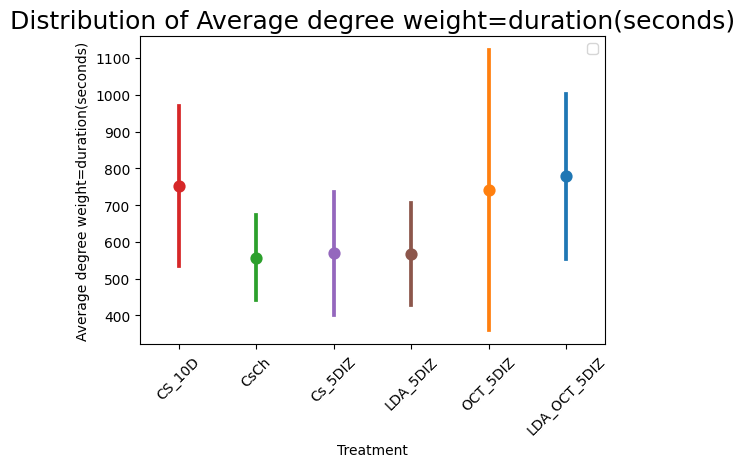

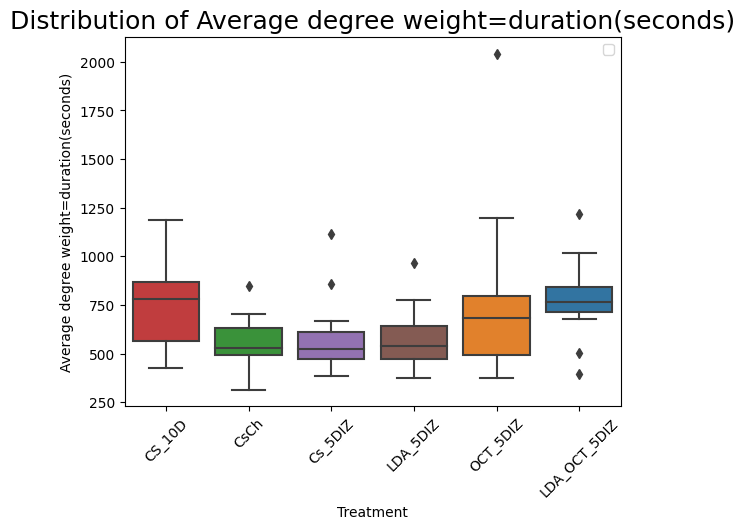

=============================================Degree heterogeneity=============================================
sum_CS_10D mean value: 0.0 SD value: 0.0
sum_CsCh mean value: 0.0 SD value: 0.0
sum_Cs_5DIZ mean value: 0.0 SD value: 0.0
sum_LDA_5DIZ mean value: 0.0 SD value: 0.0
sum_OCT_5DIZ mean value: 0.0 SD value: 0.0
sum_LDA_OCT_5DIZ mean value: 0.026377479270041245 SD value: 0.048313956871267515
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
      CS_10D         CsCh      0.0    1.0 -0.0137  0.0137  False
      CS_10D      Cs_5DIZ      0.0    1.0 -0.0142  0.0142  False
      CS_10D     LDA_5DIZ      0.0    1.0 -0.0136  0.0136  False
      CS_10D LDA_OCT_5DIZ   0.0264 0.0002  0.0096  0.0432   True
      CS_10D     OCT_5DIZ      0.0    1.0 -0.0144  0.0144  False
        CsCh      Cs_5DIZ      0.0    1.0 -0.0135  0.0135  False
        CsCh   

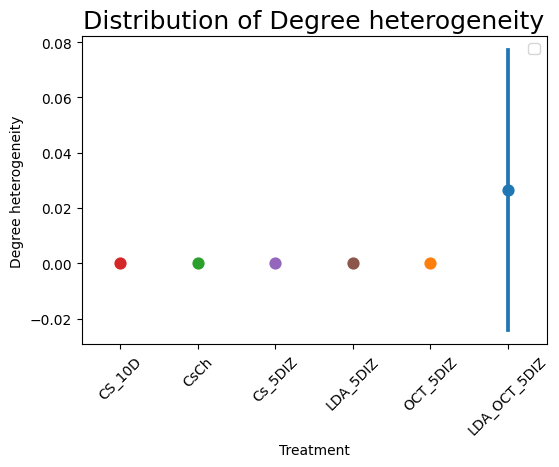

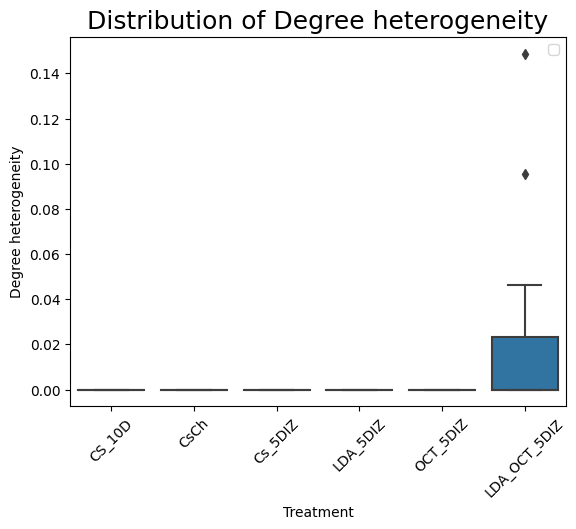

=============================================Degree aassortativity=============================================
sum_CS_10D mean value: nan SD value: nan
sum_CsCh mean value: nan SD value: nan
sum_Cs_5DIZ mean value: nan SD value: nan
sum_LDA_5DIZ mean value: nan SD value: nan
sum_OCT_5DIZ mean value: nan SD value: nan
sum_LDA_OCT_5DIZ mean value: -0.163718708827411 SD value: 0.0409914361001085
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
   group1       group2    meandiff p-adj lower upper reject
-----------------------------------------------------------
      CS_10D         CsCh      nan   nan   nan   nan  False
      CS_10D      Cs_5DIZ      nan   nan   nan   nan  False
      CS_10D     LDA_5DIZ      nan   nan   nan   nan  False
      CS_10D LDA_OCT_5DIZ      nan   nan   nan   nan  False
      CS_10D     OCT_5DIZ      nan   nan   nan   nan  False
        CsCh      Cs_5DIZ      nan   nan   nan   nan  False
        CsCh     LDA_5DIZ      nan   nan   nan   nan  False
   

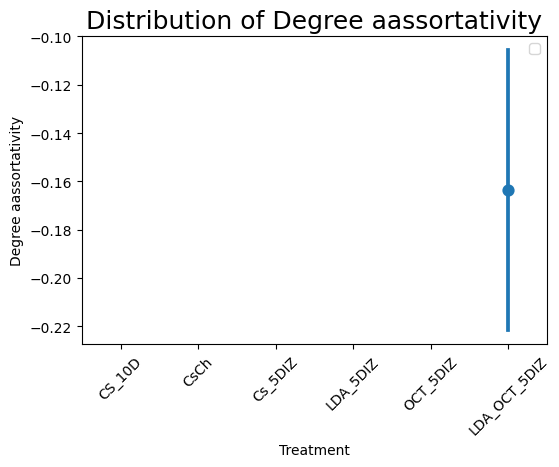

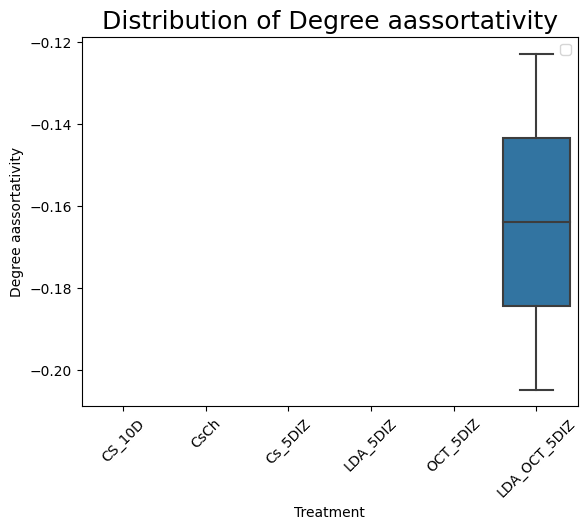

=============================================Reciprocity=============================================
sum_CS_10D mean value: 1.0 SD value: 0.0
sum_CsCh mean value: 1.0 SD value: 0.0
sum_Cs_5DIZ mean value: 1.0 SD value: 0.0
sum_LDA_5DIZ mean value: 1.0 SD value: 0.0
sum_OCT_5DIZ mean value: 1.0 SD value: 0.0
sum_LDA_OCT_5DIZ mean value: 0.9888939343484799 SD value: 0.025930519394125412
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
      CS_10D         CsCh      0.0    1.0 -0.0074  0.0074  False
      CS_10D      Cs_5DIZ      0.0    1.0 -0.0076  0.0076  False
      CS_10D     LDA_5DIZ      0.0    1.0 -0.0073  0.0073  False
      CS_10D LDA_OCT_5DIZ  -0.0111 0.0068 -0.0201 -0.0021   True
      CS_10D     OCT_5DIZ      0.0    1.0 -0.0077  0.0077  False
        CsCh      Cs_5DIZ      0.0    1.0 -0.0073  0.0073  False
        CsCh     LDA_5DIZ 

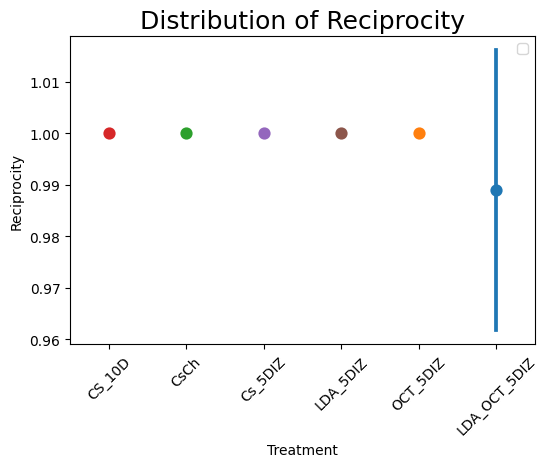

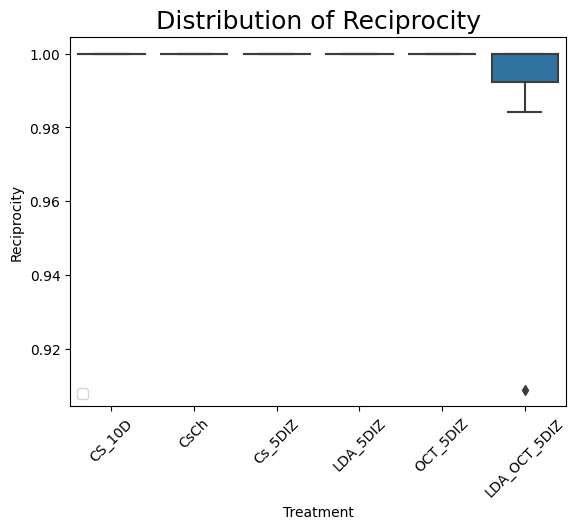

=============================================Network density=============================================
sum_CS_10D mean value: 1.0 SD value: 0.0
sum_CsCh mean value: 1.0 SD value: 0.0
sum_Cs_5DIZ mean value: 1.0 SD value: 0.0
sum_LDA_5DIZ mean value: 1.0 SD value: 0.0
sum_OCT_5DIZ mean value: 1.0 SD value: 0.0
sum_LDA_OCT_5DIZ mean value: 0.9869146005509641 SD value: 0.02586085861641679
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
      CS_10D         CsCh      0.0    1.0 -0.0074  0.0074  False
      CS_10D      Cs_5DIZ      0.0    1.0 -0.0076  0.0076  False
      CS_10D     LDA_5DIZ      0.0    1.0 -0.0073  0.0073  False
      CS_10D LDA_OCT_5DIZ  -0.0131 0.0007 -0.0221 -0.0041   True
      CS_10D     OCT_5DIZ      0.0    1.0 -0.0077  0.0077  False
        CsCh      Cs_5DIZ      0.0    1.0 -0.0073  0.0073  False
        CsCh     LDA_5D

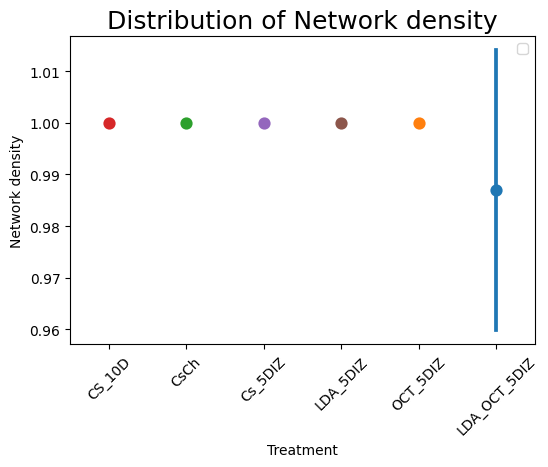

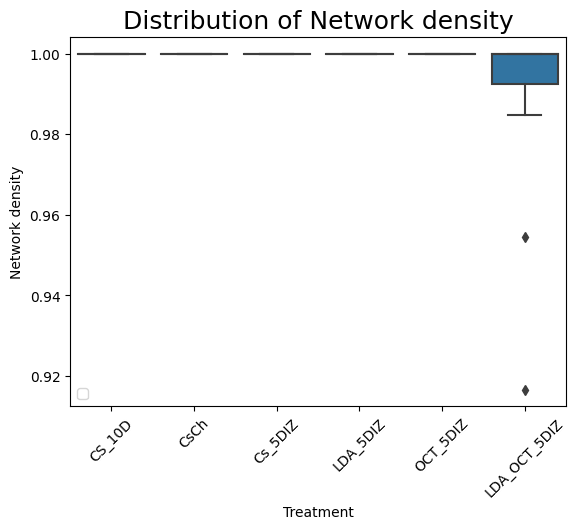

=============================================Global efficiency=============================================
sum_CS_10D mean value: 1.0 SD value: 0.0
sum_CsCh mean value: 1.0 SD value: 0.0
sum_Cs_5DIZ mean value: 1.0 SD value: 0.0
sum_LDA_5DIZ mean value: 1.0 SD value: 0.0
sum_OCT_5DIZ mean value: 1.0 SD value: 0.0
sum_LDA_OCT_5DIZ mean value: 0.9986225895316804 SD value: 0.0043557543528490355
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1       group2    meandiff p-adj   lower  upper  reject
---------------------------------------------------------------
      CS_10D         CsCh      0.0    1.0 -0.0012 0.0012  False
      CS_10D      Cs_5DIZ      0.0    1.0 -0.0013 0.0013  False
      CS_10D     LDA_5DIZ      0.0    1.0 -0.0012 0.0012  False
      CS_10D LDA_OCT_5DIZ  -0.0014 0.0965 -0.0029 0.0001  False
      CS_10D     OCT_5DIZ      0.0    1.0 -0.0013 0.0013  False
        CsCh      Cs_5DIZ      0.0    1.0 -0.0012 0.0012  False
        CsCh     LDA_5DIZ   

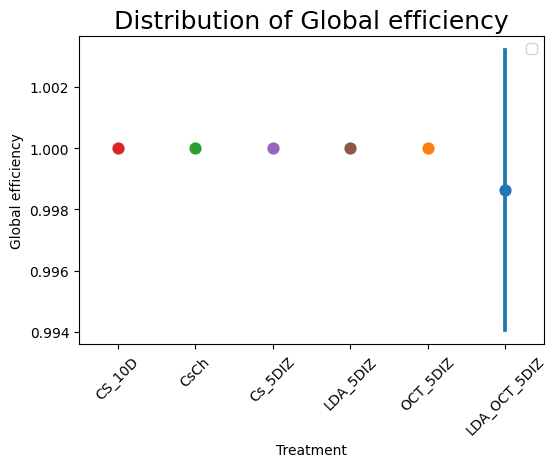

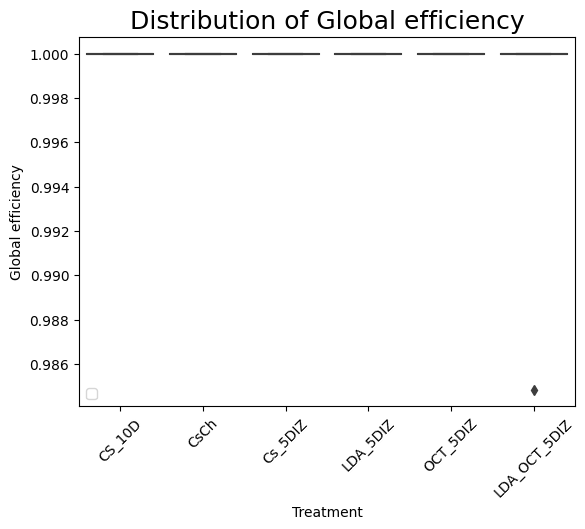

=============================================Transitivity=============================================
sum_CS_10D mean value: 1.0 SD value: 0.0
sum_CsCh mean value: 1.0 SD value: 0.0
sum_Cs_5DIZ mean value: 1.0 SD value: 0.0
sum_LDA_5DIZ mean value: 1.0 SD value: 0.0
sum_OCT_5DIZ mean value: 1.0 SD value: 0.0
sum_LDA_OCT_5DIZ mean value: 0.9868432137693077 SD value: 0.027135167136348188
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
      CS_10D         CsCh      0.0    1.0 -0.0077  0.0077  False
      CS_10D      Cs_5DIZ      0.0    1.0  -0.008   0.008  False
      CS_10D     LDA_5DIZ      0.0    1.0 -0.0076  0.0076  False
      CS_10D LDA_OCT_5DIZ  -0.0132 0.0013 -0.0226 -0.0037   True
      CS_10D     OCT_5DIZ      0.0    1.0 -0.0081  0.0081  False
        CsCh      Cs_5DIZ      0.0    1.0 -0.0076  0.0076  False
        CsCh     LDA_5DIZ

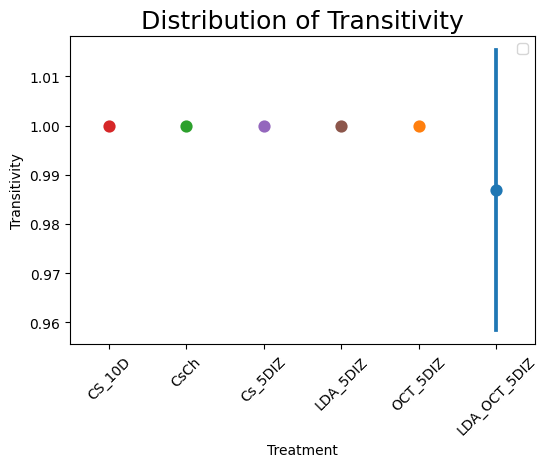

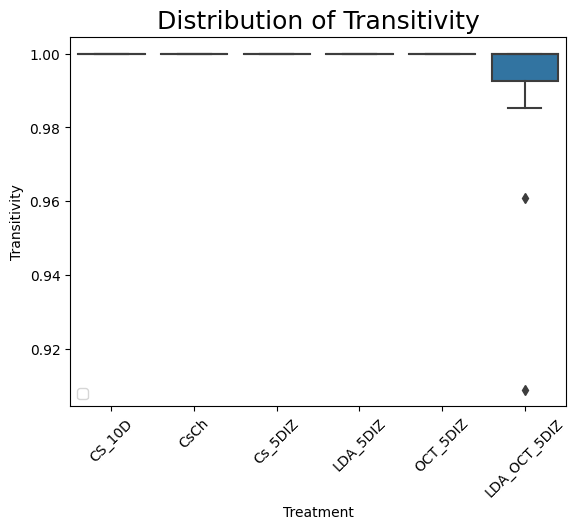

=============================================Number of connected components=============================================
sum_CS_10D mean value: 1.0 SD value: 0.0
sum_CsCh mean value: 1.0 SD value: 0.0
sum_Cs_5DIZ mean value: 1.0 SD value: 0.0
sum_LDA_5DIZ mean value: 1.0 SD value: 0.0
sum_OCT_5DIZ mean value: 1.0 SD value: 0.0
sum_LDA_OCT_5DIZ mean value: 1.0 SD value: 0.0
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
   group1       group2    meandiff p-adj lower upper reject
-----------------------------------------------------------
      CS_10D         CsCh      0.0   nan   0.0   0.0  False
      CS_10D      Cs_5DIZ      0.0   nan   0.0   0.0  False
      CS_10D     LDA_5DIZ      0.0   nan   0.0   0.0  False
      CS_10D LDA_OCT_5DIZ      0.0   nan   0.0   0.0  False
      CS_10D     OCT_5DIZ      0.0   nan   0.0   0.0  False
        CsCh      Cs_5DIZ      0.0   nan   0.0   0.0  False
        CsCh     LDA_5DIZ      0.0   nan   0.0   0.0  False
        CsCh LDA_OCT_5DI

/home/milky/drosophila-SNA/.env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/home/milky/drosophila-SNA/.env/lib/python3.8/site-packages/statsmodels/sandbox/stats/multicomp.py:1300: RuntimeWarning: invalid value encountered in divide
  st_range = np.abs(meandiffs) / std_pairs #studentized range statistic


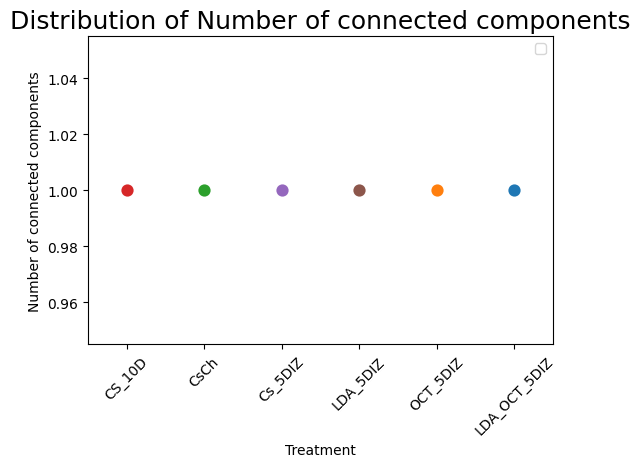

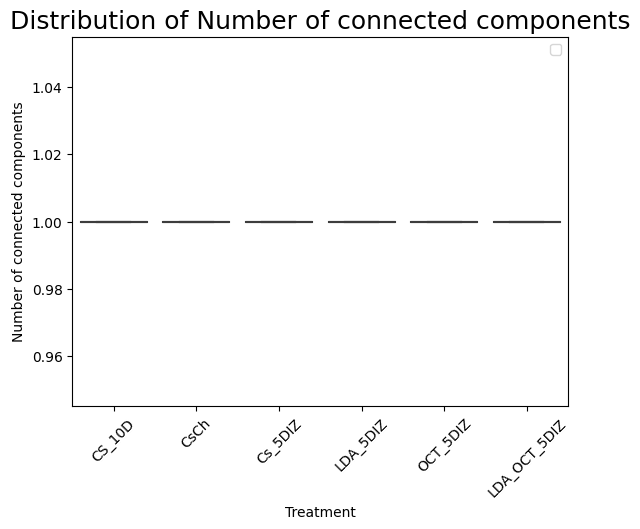

=============================================Average clustering coefficient unweighted=============================================
sum_CS_10D mean value: 1.0 SD value: 0.0
sum_CsCh mean value: 1.0 SD value: 0.0
sum_Cs_5DIZ mean value: 1.0 SD value: 0.0
sum_LDA_5DIZ mean value: 1.0 SD value: 0.0
sum_OCT_5DIZ mean value: 1.0 SD value: 0.0
sum_LDA_OCT_5DIZ mean value: 0.9912465564738292 SD value: 0.015846207995182212
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
      CS_10D         CsCh      0.0    1.0 -0.0045  0.0045  False
      CS_10D      Cs_5DIZ      0.0    1.0 -0.0047  0.0047  False
      CS_10D     LDA_5DIZ      0.0    1.0 -0.0045  0.0045  False
      CS_10D LDA_OCT_5DIZ  -0.0088 0.0002 -0.0143 -0.0032   True
      CS_10D     OCT_5DIZ      0.0    1.0 -0.0047  0.0047  False
        CsCh      Cs_5DIZ      0.0    1.0 -0.0044  0.0044  Fa

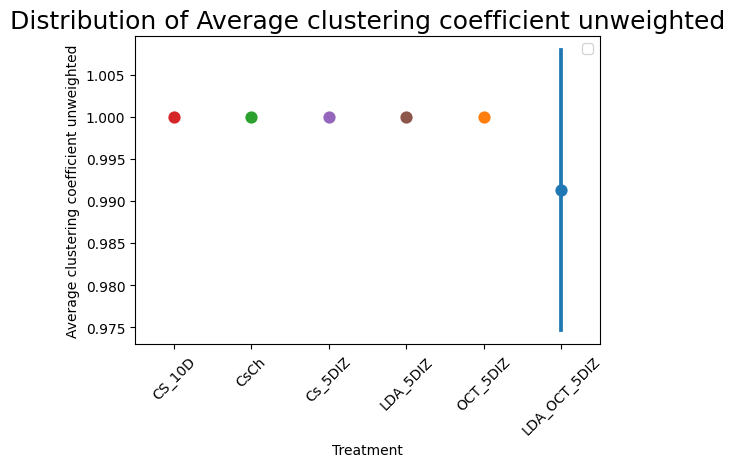

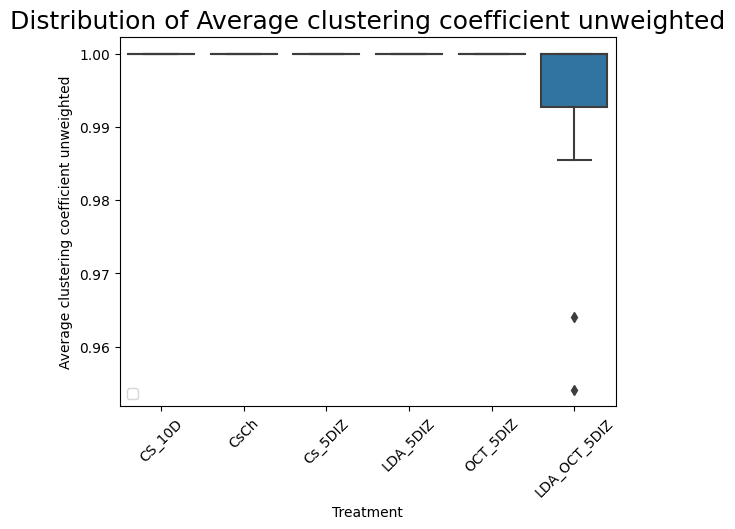

=============================================Average clustering coefficient weight=count=============================================
sum_CS_10D mean value: 0.46905737708882617 SD value: 0.08629020024970048
sum_CsCh mean value: 0.5557638704452256 SD value: 0.05470821559906106
sum_Cs_5DIZ mean value: 0.5211000342187013 SD value: 0.05367763740799122
sum_LDA_5DIZ mean value: 0.5162641030767694 SD value: 0.0651173228747064
sum_OCT_5DIZ mean value: 0.5113642513278072 SD value: 0.04847739491011162
sum_LDA_OCT_5DIZ mean value: 0.46733272268119497 SD value: 0.07298368312040489
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
      CS_10D         CsCh   0.0867 0.0006  0.0277  0.1457   True
      CS_10D      Cs_5DIZ    0.052 0.1399 -0.0089   0.113  False
      CS_10D     LDA_5DIZ   0.0472 0.1855 -0.0112  0.1056  False
      CS_10D LDA_OCT_5DIZ  -0.0017

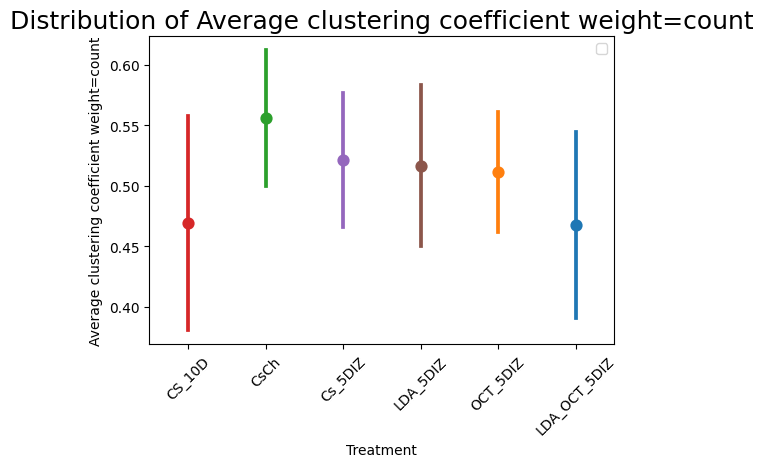

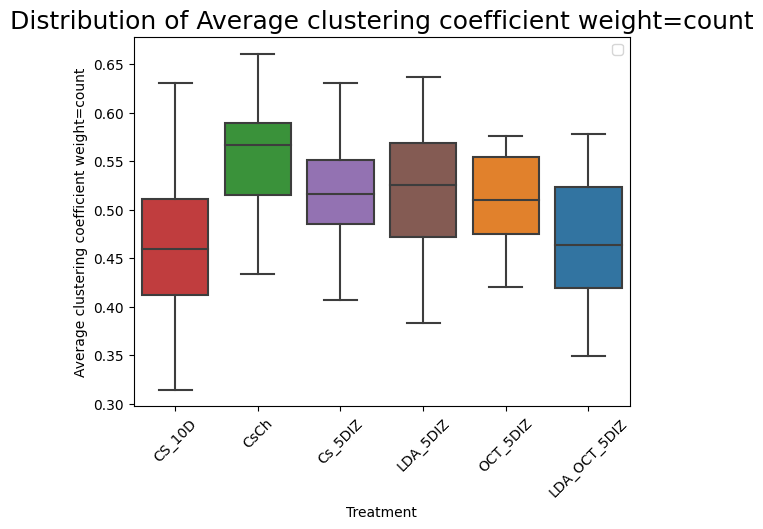

=============================================Average clustering coefficient weight=duration(seconds)=============================================
sum_CS_10D mean value: 0.2977817350424967 SD value: 0.11547309291665024
sum_CsCh mean value: 0.4634823793770365 SD value: 0.0814512896793223
sum_Cs_5DIZ mean value: 0.43543937535388866 SD value: 0.07394220504043164
sum_LDA_5DIZ mean value: 0.4167514364598393 SD value: 0.08521154873837189
sum_OCT_5DIZ mean value: 0.37902360181940675 SD value: 0.09126229833089904
sum_LDA_OCT_5DIZ mean value: 0.34080429009033003 SD value: 0.11067932174934707
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
      CS_10D         CsCh   0.1657    0.0  0.0807  0.2507   True
      CS_10D      Cs_5DIZ   0.1377 0.0002  0.0498  0.2255   True
      CS_10D     LDA_5DIZ    0.119 0.0011  0.0348  0.2032   True
      CS_10D LDA_OCT_

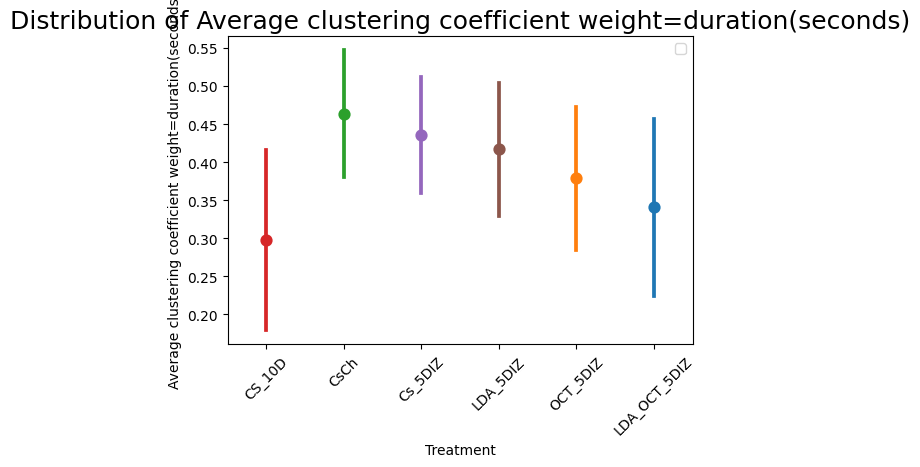

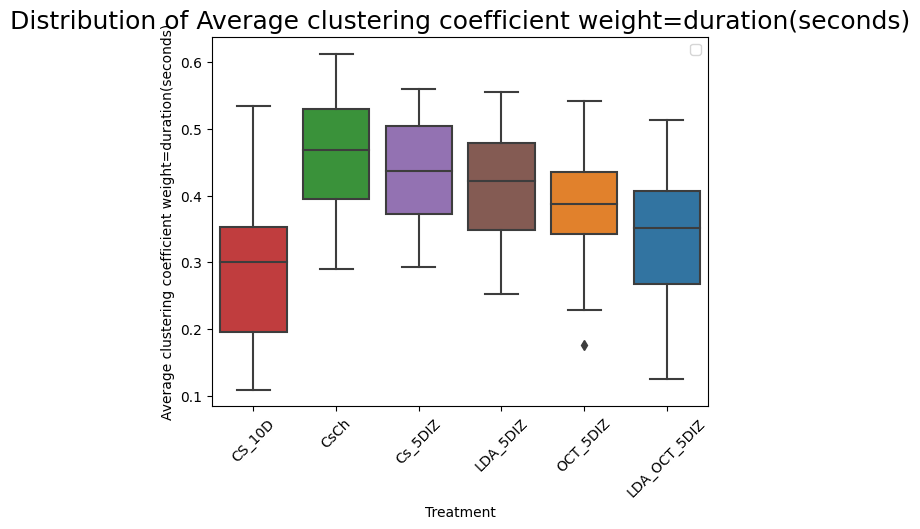

=============================================Average betweenness centrality unweighted=============================================
sum_CS_10D mean value: 0.0 SD value: 0.0
sum_CsCh mean value: 0.0 SD value: 0.0
sum_Cs_5DIZ mean value: 0.0 SD value: 0.0
sum_LDA_5DIZ mean value: 0.0 SD value: 0.0
sum_OCT_5DIZ mean value: 0.0 SD value: 0.0
sum_LDA_OCT_5DIZ mean value: 0.0005509641873278182 SD value: 0.0013354489965334106
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
      CS_10D         CsCh      0.0    1.0 -0.0004  0.0004  False
      CS_10D      Cs_5DIZ      0.0    1.0 -0.0004  0.0004  False
      CS_10D     LDA_5DIZ      0.0    1.0 -0.0004  0.0004  False
      CS_10D LDA_OCT_5DIZ   0.0006 0.0103  0.0001   0.001   True
      CS_10D     OCT_5DIZ      0.0    1.0 -0.0004  0.0004  False
        CsCh      Cs_5DIZ      0.0    1.0 -0.0004  0.0004

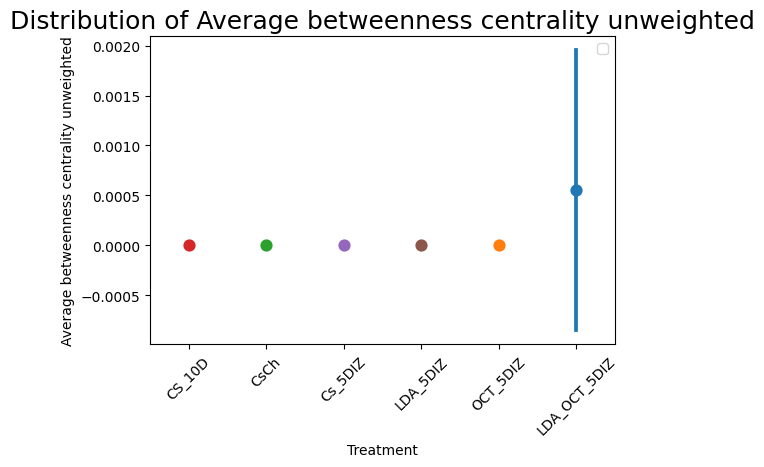

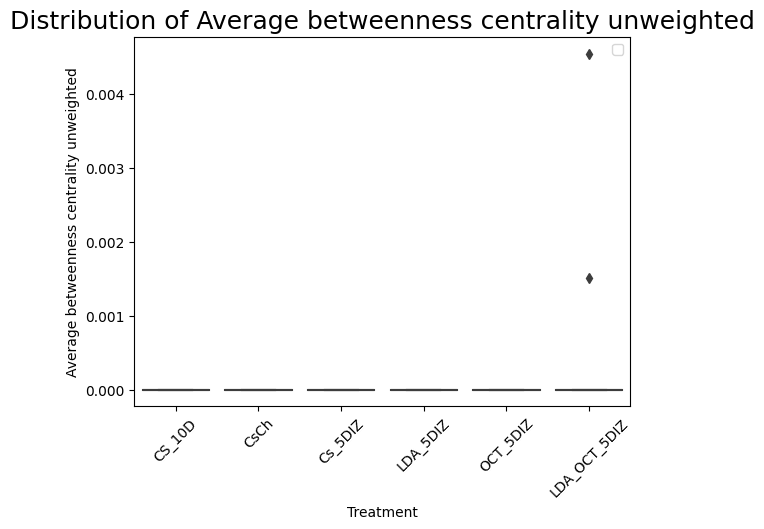

=============================================Average betweenness centrality weight=count=============================================
sum_CS_10D mean value: 0.028977272727272678 SD value: 0.018589707734667796
sum_CsCh mean value: 0.009464207290294197 SD value: 0.006168015768637731
sum_Cs_5DIZ mean value: 0.01411931818181813 SD value: 0.01049080737505689
sum_LDA_5DIZ mean value: 0.012052819865319822 SD value: 0.009496733232405291
sum_OCT_5DIZ mean value: 0.01578282828282822 SD value: 0.010193538855112606
sum_LDA_OCT_5DIZ mean value: 0.03287419651056012 SD value: 0.028456942290220395
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
      CS_10D         CsCh  -0.0195 0.0004 -0.0324 -0.0066   True
      CS_10D      Cs_5DIZ  -0.0149 0.0198 -0.0282 -0.0015   True
      CS_10D     LDA_5DIZ  -0.0169 0.0028 -0.0297 -0.0041   True
      CS_10D LDA_OCT_

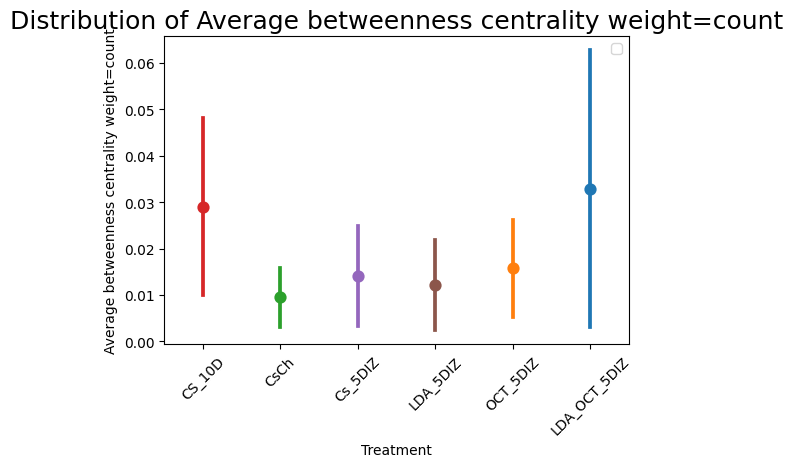

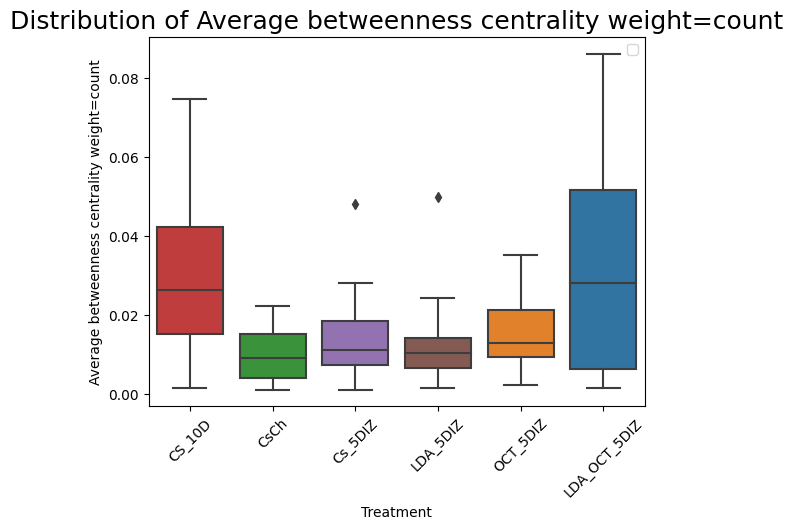

=============================================Average betweenness centrality weight=duration(seconds)=============================================
sum_CS_10D mean value: 0.04021132376395529 SD value: 0.020230424626260294
sum_CsCh mean value: 0.01609025032938072 SD value: 0.008011099516305636
sum_Cs_5DIZ mean value: 0.022253787878787838 SD value: 0.009467329249452506
sum_LDA_5DIZ mean value: 0.01904987373737369 SD value: 0.009603523546495109
sum_OCT_5DIZ mean value: 0.02416267942583728 SD value: 0.009064770826096602
sum_LDA_OCT_5DIZ mean value: 0.04359504132231398 SD value: 0.03297826738167121
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
      CS_10D         CsCh  -0.0241    0.0 -0.0382 -0.0101   True
      CS_10D      Cs_5DIZ   -0.018 0.0064 -0.0325 -0.0035   True
      CS_10D     LDA_5DIZ  -0.0212 0.0003 -0.0351 -0.0073   True
      CS_10

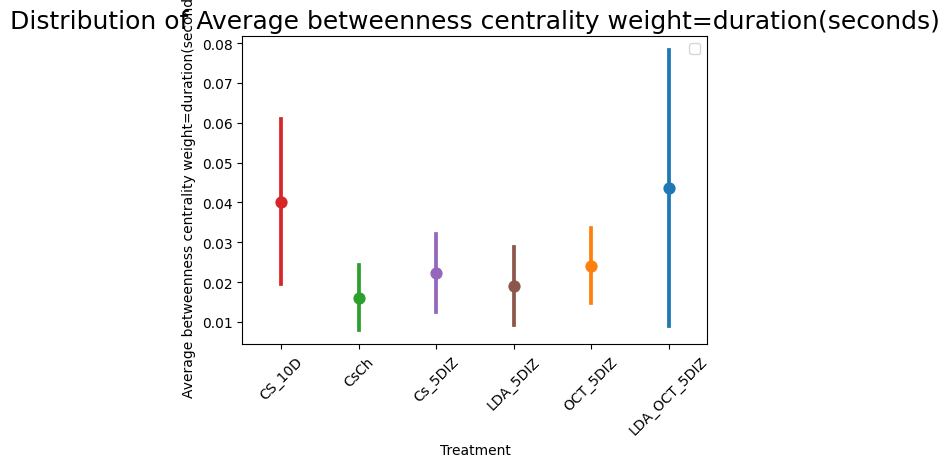

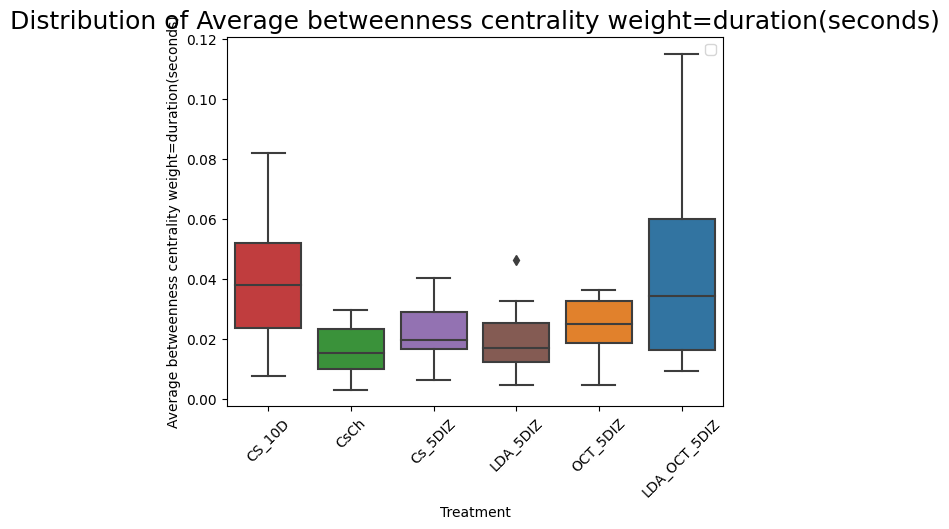

=============================================Average closseness centrality unweighted=============================================
sum_CS_10D mean value: 1.0 SD value: 0.0
sum_CsCh mean value: 1.0 SD value: 0.0
sum_Cs_5DIZ mean value: 1.0 SD value: 0.0
sum_LDA_5DIZ mean value: 1.0 SD value: 0.0
sum_OCT_5DIZ mean value: 1.0 SD value: 0.0
sum_LDA_OCT_5DIZ mean value: 0.9876443001443 SD value: 0.025145037679056067
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
      CS_10D         CsCh      0.0    1.0 -0.0072  0.0072  False
      CS_10D      Cs_5DIZ      0.0    1.0 -0.0074  0.0074  False
      CS_10D     LDA_5DIZ      0.0    1.0 -0.0071  0.0071  False
      CS_10D LDA_OCT_5DIZ  -0.0124 0.0011 -0.0211 -0.0036   True
      CS_10D     OCT_5DIZ      0.0    1.0 -0.0075  0.0075  False
        CsCh      Cs_5DIZ      0.0    1.0 -0.0071  0.0071  False


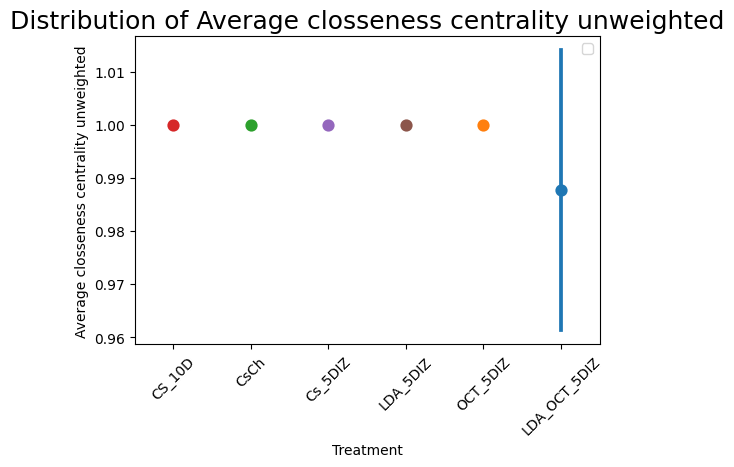

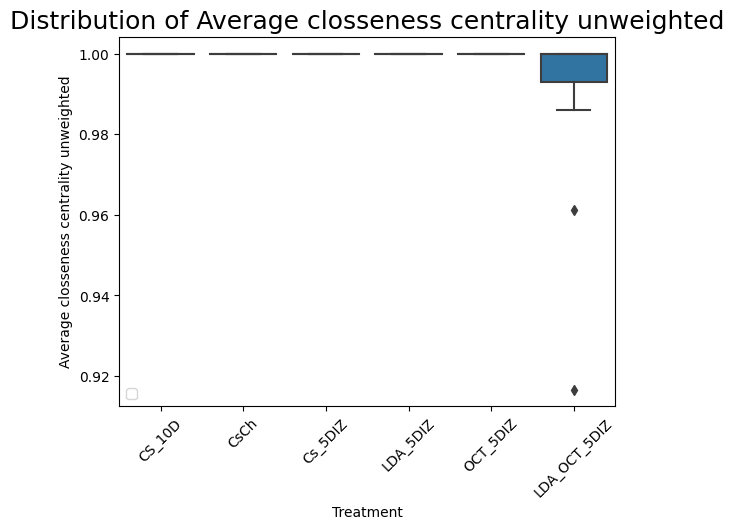

=============================================Average closseness centrality weight=count=============================================
sum_CS_10D mean value: 0.06898073368998663 SD value: 0.0212236086057403
sum_CsCh mean value: 0.048262206123648614 SD value: 0.008849721606277396
sum_Cs_5DIZ mean value: 0.05474269075680921 SD value: 0.005950450334338696
sum_LDA_5DIZ mean value: 0.05142047472328939 SD value: 0.009379412907781545
sum_OCT_5DIZ mean value: 0.04963995462300406 SD value: 0.006264932786660937
sum_LDA_OCT_5DIZ mean value: 0.0584426208501094 SD value: 0.020132016429941654
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
      CS_10D         CsCh  -0.0207    0.0 -0.0323 -0.0091   True
      CS_10D      Cs_5DIZ  -0.0142 0.0105 -0.0263 -0.0022   True
      CS_10D     LDA_5DIZ  -0.0176 0.0003 -0.0291  -0.006   True
      CS_10D LDA_OCT_5DIZ 

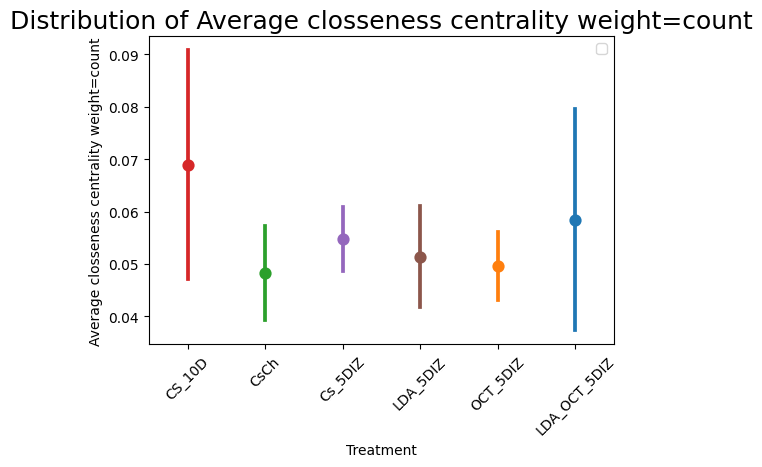

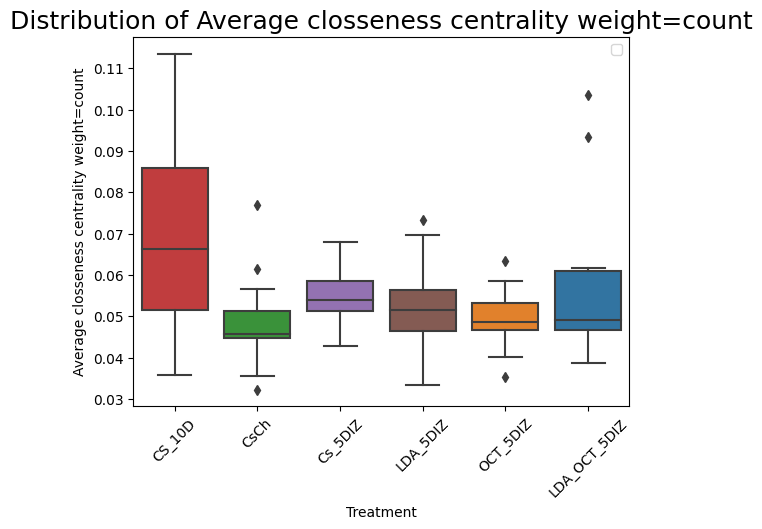

=============================================Average closseness centrality weight=duration(seconds)=============================================
sum_CS_10D mean value: 0.042101435849567645 SD value: 0.010342317467542364
sum_CsCh mean value: 0.04371410562797744 SD value: 0.00964992231695821
sum_Cs_5DIZ mean value: 0.04435685565020324 SD value: 0.00862147018176553
sum_LDA_5DIZ mean value: 0.04414798546331553 SD value: 0.009727875205472924
sum_OCT_5DIZ mean value: 0.038232687650108996 SD value: 0.012330735265260658
sum_LDA_OCT_5DIZ mean value: 0.039037837227473574 SD value: 0.009825989401682781
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1       group2    meandiff p-adj   lower  upper  reject
---------------------------------------------------------------
      CS_10D         CsCh   0.0016 0.9961 -0.0077  0.011  False
      CS_10D      Cs_5DIZ   0.0023 0.9841 -0.0074 0.0119  False
      CS_10D     LDA_5DIZ    0.002 0.9876 -0.0072 0.0113  False
      CS_10D LDA_

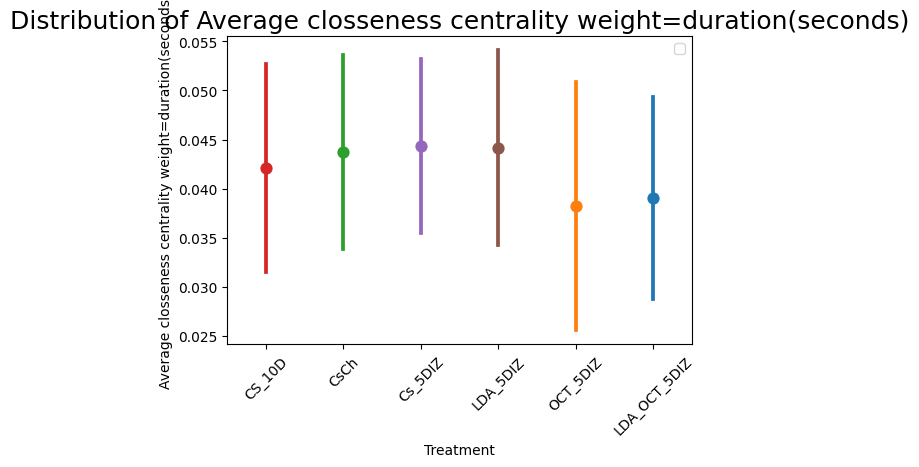

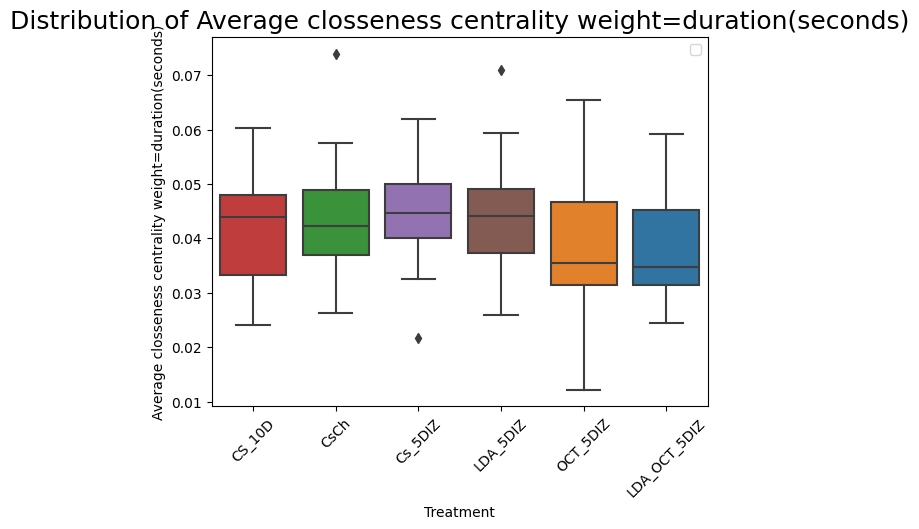

=============================================Newman modularity unweighted=============================================
sum_CS_10D mean value: 0.0 SD value: 0.0
sum_CsCh mean value: 0.0 SD value: 0.0
sum_Cs_5DIZ mean value: 0.0 SD value: 0.0
sum_LDA_5DIZ mean value: 0.0 SD value: 0.0
sum_OCT_5DIZ mean value: 0.0 SD value: 0.0
sum_LDA_OCT_5DIZ mean value: 0.0 SD value: 0.0
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
   group1       group2    meandiff p-adj lower upper reject
-----------------------------------------------------------
      CS_10D         CsCh      0.0   nan   0.0   0.0  False
      CS_10D      Cs_5DIZ      0.0   nan   0.0   0.0  False
      CS_10D     LDA_5DIZ      0.0   nan   0.0   0.0  False
      CS_10D LDA_OCT_5DIZ      0.0   nan   0.0   0.0  False
      CS_10D     OCT_5DIZ      0.0   nan   0.0   0.0  False
        CsCh      Cs_5DIZ      0.0   nan   0.0   0.0  False
        CsCh     LDA_5DIZ      0.0   nan   0.0   0.0  False
        CsCh LDA_OCT_5DIZ 

/home/milky/drosophila-SNA/.env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/home/milky/drosophila-SNA/.env/lib/python3.8/site-packages/statsmodels/sandbox/stats/multicomp.py:1300: RuntimeWarning: invalid value encountered in divide
  st_range = np.abs(meandiffs) / std_pairs #studentized range statistic


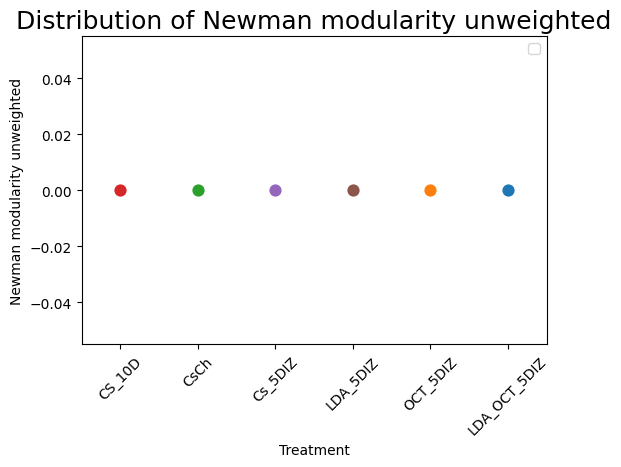

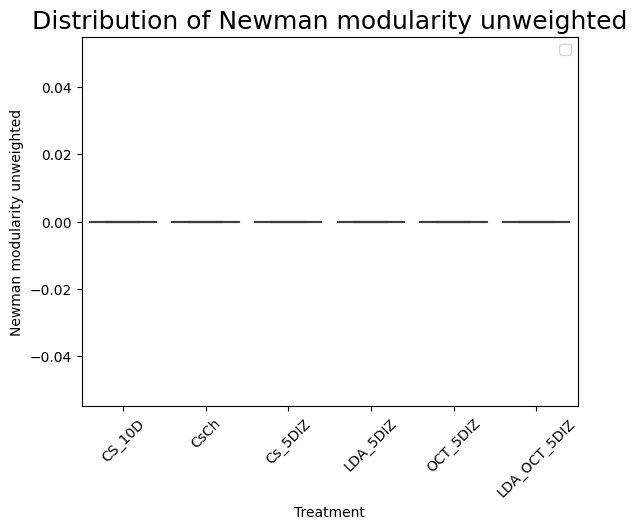

=============================================Newman_modularity weight=count=============================================
sum_CS_10D mean value: 0.0 SD value: 0.0
sum_CsCh mean value: 0.0 SD value: 0.0
sum_Cs_5DIZ mean value: 0.0 SD value: 0.0
sum_LDA_5DIZ mean value: 0.0 SD value: 0.0
sum_OCT_5DIZ mean value: 0.0 SD value: 0.0
sum_LDA_OCT_5DIZ mean value: 0.0 SD value: 0.0
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
   group1       group2    meandiff p-adj lower upper reject
-----------------------------------------------------------
      CS_10D         CsCh      0.0   nan   0.0   0.0  False
      CS_10D      Cs_5DIZ      0.0   nan   0.0   0.0  False
      CS_10D     LDA_5DIZ      0.0   nan   0.0   0.0  False
      CS_10D LDA_OCT_5DIZ      0.0   nan   0.0   0.0  False
      CS_10D     OCT_5DIZ      0.0   nan   0.0   0.0  False
        CsCh      Cs_5DIZ      0.0   nan   0.0   0.0  False
        CsCh     LDA_5DIZ      0.0   nan   0.0   0.0  False
        CsCh LDA_OCT_5DI

/home/milky/drosophila-SNA/.env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/home/milky/drosophila-SNA/.env/lib/python3.8/site-packages/statsmodels/sandbox/stats/multicomp.py:1300: RuntimeWarning: invalid value encountered in divide
  st_range = np.abs(meandiffs) / std_pairs #studentized range statistic


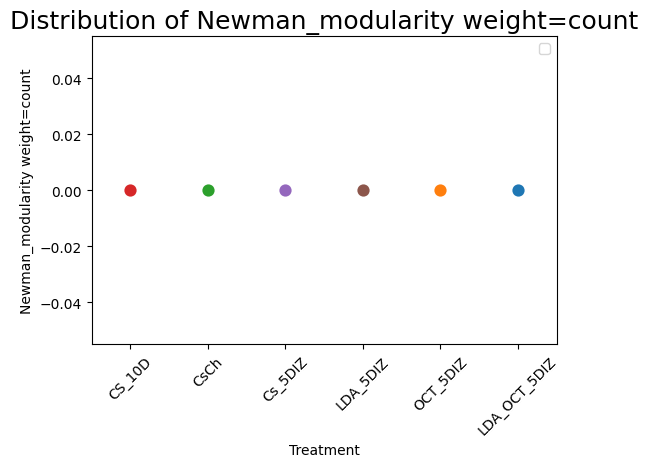

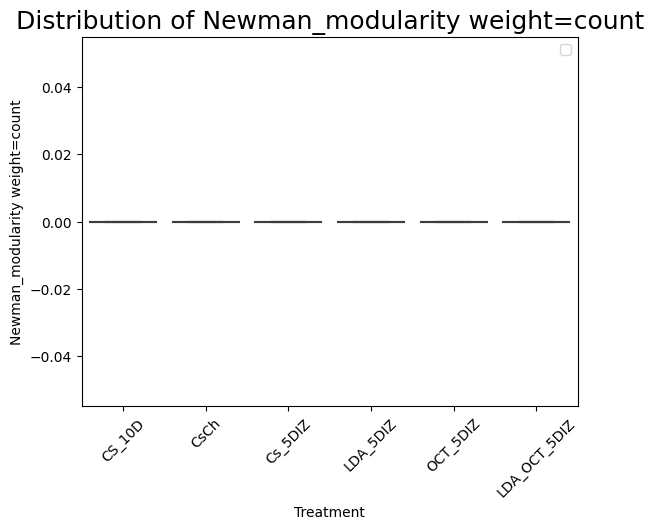

=============================================Newman_modularity weight=dration(seconds)=============================================
sum_CS_10D mean value: -5.843279076974507e-18 SD value: 2.4555680751285767e-16
sum_CsCh mean value: 1.2550347234893073e-16 SD value: 2.783835163412496e-16
sum_Cs_5DIZ mean value: 1.3877787807814457e-16 SD value: 3.473330558936429e-16
sum_LDA_5DIZ mean value: -4.625929269271485e-18 SD value: 3.2759288201299133e-16
sum_OCT_5DIZ mean value: -9.349246523159212e-17 SD value: 3.4410911230021673e-16
sum_LDA_OCT_5DIZ mean value: 4.0371746350005693e-17 SD value: 3.968462579023724e-16
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1       group2    meandiff p-adj  lower upper reject
------------------------------------------------------------
      CS_10D         CsCh      0.0 0.7909  -0.0   0.0  False
      CS_10D      Cs_5DIZ      0.0 0.7432  -0.0   0.0  False
      CS_10D     LDA_5DIZ      0.0    1.0  -0.0   0.0  False
      CS_10D LDA_OCT_5

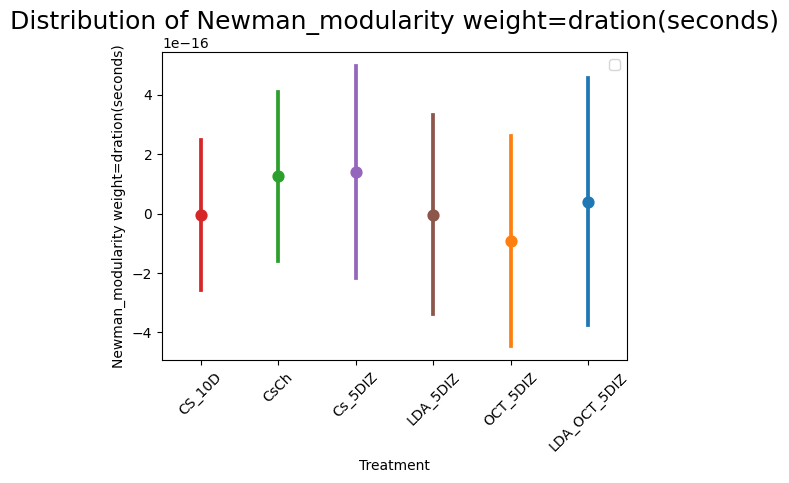

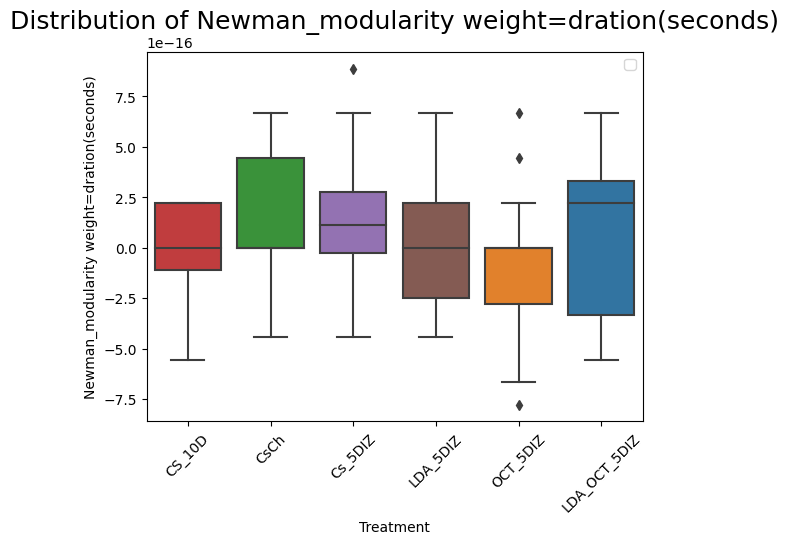

In [7]:
import os
import toml
import scipy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from src import settings
from src.utils import fileio

CONFIG_PATH = os.path.join(settings.CONFIG_DIR, 'main.toml')
with open(CONFIG_PATH, 'r') as file:
    config = toml.load(file)  

TREATMENTS = config['TREATMENTS']

INPUT_PATH = os.path.join(settings.RESULTS_DIR, 'global_measures')
all_treatments = fileio.load_files_from_folder(INPUT_PATH)

dataframes = []
for treatment_name, treatment_path in all_treatments.items():
    treatment_name = treatment_name.replace('.csv', '')
    if treatment_name in config['TREATMENTS']:
        df = pd.read_csv(treatment_path, index_col=0)
        df['Treatment'] = treatment_name
        dataframes.append(df)

combined_data = pd.concat(dataframes)
combined_data_reset = combined_data.reset_index()

for measure_name in combined_data.columns.tolist():
    if measure_name == 'Treatment': continue
    
    treatment_sums = {}
    for treatment in TREATMENTS:
        treatment_sums[f'sum_{treatment}'] = combined_data_reset[combined_data_reset['Treatment'] == treatment][measure_name]

    anova_result = scipy.stats.f_oneway(*treatment_sums.values())

    all_data = np.concatenate([*treatment_sums.values()])
    group_labels = []
    for treatment in TREATMENTS:
        group_labels.extend([treatment] * len(combined_data_reset[combined_data_reset['Treatment'] == treatment][measure_name]))

    tukey_results = pairwise_tukeyhsd(all_data, group_labels)

    print('=' * 45 + measure_name + '=' * 45)

    for treatment in treatment_sums.keys():
        print(f"{treatment} mean value: {np.mean(treatment_sums[treatment])} SD value: {np.std(treatment_sums[treatment])}")

    print(tukey_results)

    plt.figure(figsize=(6, 4))
    order = TREATMENTS
    sns.pointplot(data=combined_data_reset, x='Treatment', y=measure_name, dodge=False, hue='Treatment', errorbar='sd', order=order)
    
    plt.xlabel('Treatment')
    plt.xticks(rotation=45)
    plt.ylabel(measure_name)
    plt.title(f'Distribution of {measure_name}', fontsize=18)
    plt.legend('')
    plt.show() 
    print('='*90)
        
    sns.boxplot(data=combined_data_reset, x='Treatment', y=measure_name, dodge=False, hue='Treatment', order=order)
    plt.xlabel('Treatment')
    plt.xticks(rotation=45)
    plt.ylabel(measure_name)
    plt.title(f'Distribution of {measure_name}', fontsize=18)
    plt.legend('')
    plt.show() 
    print('='*90)